<a href="https://colab.research.google.com/github/GiX7000/deep-learning-with-tensorflow/blob/main/Part6.computer-vision%26transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with TensorFlow with Laurence Moroney, Part6

This notebook includes advanced computer vision examples.

Multi class is that you train your network to recognize more than one class. Multi label is when you do inference on your image to detect more than one thing in the image.

Combining multi-label classification and object localization gives you object detection. Object detection models classify all objects present in the image with confidence scores, and it predicts that bounding boxes as well. Popular algorithms for object detection are R-CNN, Faster-RCNN, YOLO and SSD.

In instance segmentation, multiple objects of the same class are regarded as separate segments. For example, each person is treated as a separate segment, though they all belong to the same class, person. One popular algorithm that solves instance segmentation is Mask R-CNN.

In semantic segmentation, all objects of the same type form a single classification. For example, all six people highlighted as one item. The word semantic refers to meaning to all parts of the image that have the same meaning. Popular machine learning models that solve semantic segmentation are: Fully Convolutional Neural Networks, U-net, DeepLab, etc.

Transfer learning is a methodology that can save you some time and effort when building and trading your models. Here, we start building our own models using transfer learning. 2 of the reasons why you would want to use transfer learning: 1) it saved time and cost and 2) we take improved performance with smaller datasets. How to use transfer learning: 1) freeze the weights that have been transferred over from earlier layers(feature extractors) from the pre-trained model, 2) retrain entirely without freezing the convolutions, but to use the transferred weights as the starting points.

## Example 1. Binary Classification with Transfer Learning on Cats and Dogs Dataset using InceptionV3.

In [ ]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [ ]:
# Dowload and extract file into directory
data_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
data_file_name = "catsdogs.zip"
download_dir = "/tmp/"
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [ ]:
# Check that the dataset has the expected number of examples.
print("Number of cat images:",len(os.listdir("/tmp/PetImages/Cat/")))
print("Number of dog images:",len(os.listdir("/tmp/PetImages/Dog/")))

Number of cat images: 12501
Number of dog images: 12501


In [ ]:
# Create some folders that will store the training and test data
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [ ]:
# Split data into training and test sets
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [ ]:
# Check that the training and test sets are the expected lengths.
print("Number of training cat images", len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

Number of training cat images 11250
Number of training dog images 11250
Number of testing cat images 1250
Number of testing dog images 1250


In [ ]:
# use the ImageDataGenerator to perform data augmentation
TRAINING_DIR = "/tmp/cats-v-dogs/training"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest")
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Freezing the pre-trained layers and use of pre-trained weights is the first way of how to use transfer learning.

In [ ]:
# Get and prepare the model inception_v3
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None) # weights=None, because we set the weights below

# Load pretrained weights
pre_trained_model.load_weights(weights_file)

# free the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

# let's see how the pre-trained model looks like
pre_trained_model.summary()

# let's define the output of layer of the pre-trained model, and this will be the input of our classifier!
last_layer = pre_trained_model.get_layer("mixed7")
print("Last layer output shape: ", last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [ ]:
# Add layers

# Flatten the output into 1-D
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and Relu activation
x = layers.Dense(1024, activation="relu")(x)
# Add a final sigmoid layer for activation
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(pre_trained_model.input, x)

In [ ]:
# compile the model
model.compile(optimizer=RMSprop(lr=1e-4),
              loss="binary_crossentropy",
              metrics=["acc"])

# train the model 
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=5,
                    verbose=1)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/5
  6/225 [..............................] - ETA: 17:26 - loss: 0.3178 - acc: 0.9067

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

225/225 [==============================] - 1163s 5s/step - loss: 0.1448 - acc: 0.9435 - val_loss: 0.0689 - val_acc: 0.9740
Epoch 2/5
225/225 [==============================] - 1156s 5s/step - loss: 0.1294 - acc: 0.9483 - val_loss: 0.0656 - val_acc: 0.9760
Epoch 3/5
225/225 [==============================] - 1150s 5s/step - loss: 0.1303 - acc: 0.9498 - val_loss: 0.0639 - val_acc: 0.9728
Epoch 4/5
225/225 [==============================] - 1167s 5s/step - loss: 0.1190 - acc: 0.9547 - val_loss: 0.0643 - val_acc: 0.9756
Epoch 5/5
225/225 [==============================] - 1147s 5s/step - loss: 0.1218 - acc: 0.9519 - val_loss: 0.0590 - val_acc: 0.9784


<Figure size 432x288 with 0 Axes>

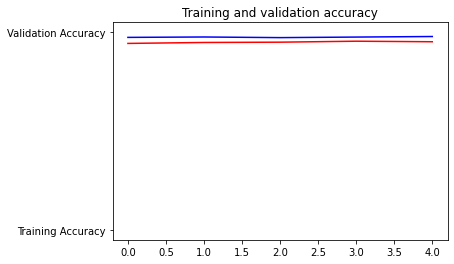

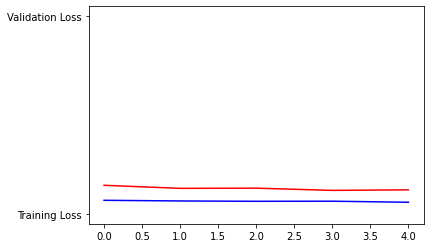

<Figure size 432x288 with 0 Axes>

In [ ]:
# Visualize training and validation accuracy
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.figure()

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

Saving dog2.jpg to dog2 (1).jpg
Saving dog1.jpg to dog1 (1).jpg
Saving cat2.jpg to cat2 (1).jpg
Saving cat1.jpg to cat1 (1).jpg
1/1 [==============================] - 0s 84ms/step
[[1.]]
[1.]
dog2.jpg is a dog
1/1 [==============================] - 0s 82ms/step
[[0.]]
[0.]
dog1.jpg is a cat
1/1 [==============================] - 0s 293ms/step
[[0.]]
[0.]
cat2.jpg is a cat
1/1 [==============================] - 0s 95ms/step
[[0.]]
[0.]
cat1.jpg is a cat


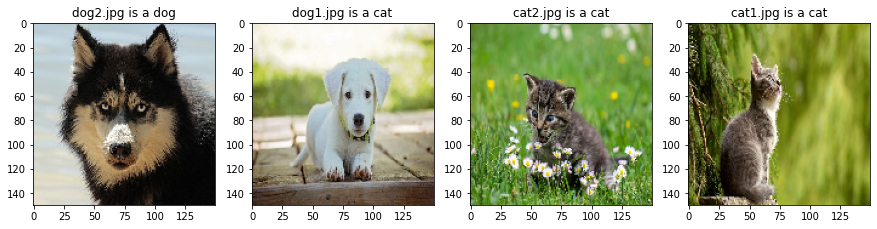

In [ ]:
# prediction on an image
import numpy as np
from google.colab import files
import keras.utils as image

uploaded = files.upload()
plt.figure(figsize=(15, 30))

n_images = len(uploaded.keys())


for idx, fn in enumerate(uploaded.keys()):
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  
  plt.subplot(1, n_images,idx+1 )
  plt.imshow(img)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  image_tensor = np.vstack([x])

  classes = model.predict(image_tensor)
  
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
    plt.title(fn + " is a dog")
  else:
    print(fn + " is a cat")
    plt.title(fn + " is a cat")
plt.show()

## Example 2. Multi-Classification with Transfer Learning on CIFAR-10 Dataset using ResNet50.

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

%matplotlib inline
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2


In [ ]:
# parameters
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# functions for visualization

#@title Visualization Utilities [RUN ME]
# matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor="F8F8F8", titlesize="large", edgecolor="white")
plt.rc('text', color="A8151A")
plt.rc('figure', facecolor="F0F0F0")
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.yticks([])
    plt.xticks([])
    plt.imshow(n_digits[i])
  plt.show()
  
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
# Loading and Preprocessing Data
# CIFAR-10 dataset has 32 x 32 RGB images belonging to 10 classes. You will load the dataset from Keras.
(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 20s 0us/step


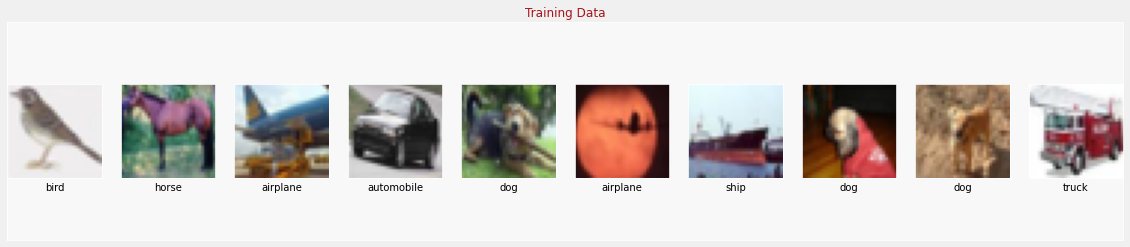

In [ ]:
# Visualize some images and their labels in training data
display_images(training_images, training_labels, training_labels, "Training Data")

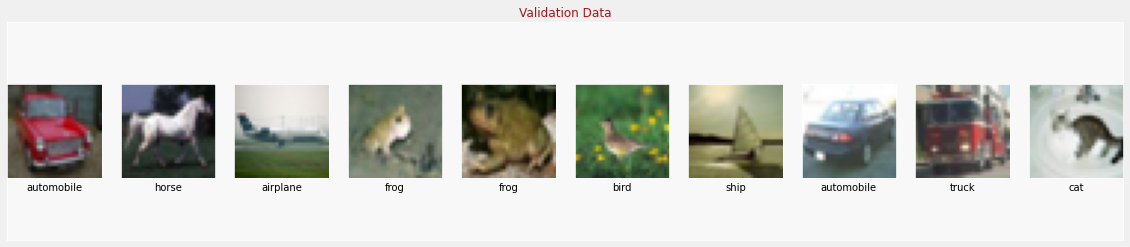

In [ ]:
# Visualize some images and their labels in validation data
display_images(validation_images, validation_labels, validation_labels, "Validation Data")

In [ ]:
# Preprocess Dataset
# we perform normalization on images in training and validation set by using the function preprocess_input from the ResNet50 model in Keras

def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_images = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_images

In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In the below feature_extraction function, We can specify the weights that we want. TensorFlow will allow us to initialize this with none, so we can clear the weights and just use the model architecture. Here we're going to set the weights to image net in order to use the image net learned weights. If we have our own weights that we want to use, we can just specify a path to the file that contains those weights. Remember, we're not freezing the values we are going to retrain them. But by specifying imagenet as the weights here, we're starting from a point where they've already been learned. And we'll get better results than if we just started with random weights. This method of using pre-trained weights and further training them on our own data set is called fine-tuning(second way of how to use transfer learning).

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
'''
def feature_extractor(inputs):
  
  feature_extractor = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                                     include_top=False,
                                                     weights='imagenet')(inputs)  # pre-trained model uses its pretrained weights!!
  return feature_extractor


# Note that we put weights='imagenet', meaning training includes both our added dense layers as well as the 50 pre trained layers of ResNet 50
# Because we are going to update the pre trained ResNet weights instead of just freezing and reusing those pre trained weights 
# Even though updating more layers will cost us more in both time and computation
# This will allow the model more flexibility to adjust to the CIFAR 10 dataset during training

# The input shape for resnet 50 is specified as 224 by 224 by 3, as you will recall that resnet 50 was trained on images of this dimension. 
# Now, you might think that you could specify 32 by 32 by 3 instead to fit the CFR image dimensions. We certainly could, but training the
# network with a 32 by 32 image directly will produce very poor results. So to obtain a better performing model we'll upscale the images
# to 224 by 224 before sending these as inputs into the resnet 50 layer object.

# By specifying include top equals false will remove the top most layers from the model, the top of the model is the end with the predicted
# outputs. The top our last layer of resnet 50 has a 100 neuron dense classification layer. Now we don't want to use this top layer, since
# it's used to predict amongst 50 categories and other 10 classes that we want to predict.

'''
Defines final dense layers and subsequent softmax layer for classification
'''
def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
  return x

'''
Since input size is (32x32), first upsample the image by factor of (7x7) to transform it to (224x224)
Connect the feature extraction and "classifier" layers to build the model
'''
def final_model(inputs):

  resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs) # size=(7,7) is the factor to upsampe!!

  resnet_feature_extractor = feature_extractor(resize)
  classification_output = classifier(resnet_feature_extractor)

  return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer
Use Sparse Categorical Crossentropy as the loss function
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  return model

model = define_compile_model()

model.summary()

94765736/94765736 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

ResNet Architecture is designed for 224 by 224 images. But our CIFAR images are just 32 by 32. So, we need to upsample the images, to convert the 32 by 32 images, into 224 by 224 ones. Upsampling takes an image, and create a copy of it with more pixels by mapping a single input pixel to several. There's a built in layer type in TensorFlow, called upsampling 2d that can handle this for us.

In [ ]:
# Train the model
EPOCHS = 4
history = model.fit(train_X, training_labels,
                    epochs=EPOCHS,
                    validation_data=(valid_X, validation_labels))

Epoch 1/4
1563/1563 [==============================] - 699s 439ms/step - loss: 0.3478 - accuracy: 0.8826 - val_loss: 0.2484 - val_accuracy: 0.9192
Epoch 2/4
1563/1563 [==============================] - 686s 439ms/step - loss: 0.0939 - accuracy: 0.9686 - val_loss: 0.1649 - val_accuracy: 0.9477
Epoch 3/4
1563/1563 [==============================] - 680s 435ms/step - loss: 0.0392 - accuracy: 0.9877 - val_loss: 0.1689 - val_accuracy: 0.9474
Epoch 4/4
1563/1563 [==============================] - 681s 436ms/step - loss: 0.0194 - accuracy: 0.9940 - val_loss: 0.1520 - val_accuracy: 0.9574


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 46s 284ms/step - loss: 0.1520 - accuracy: 0.9574


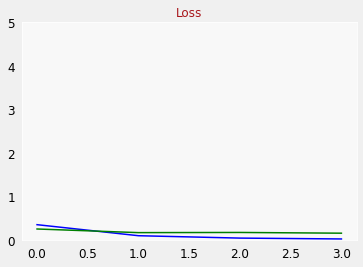

In [ ]:
# Plot the training loss (in blue) and validation loss (in green)
plot_metrics("loss", "Loss")

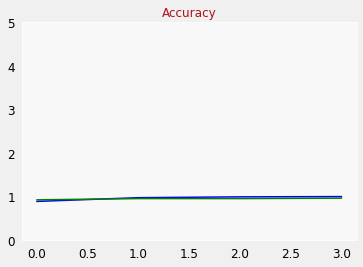

In [ ]:
# Plot the training accuracy (blue) as well as the validation accuracy (green)
plot_metrics("accuracy", "Accuracy")

157/157 [==============================] - 34s 211ms/step


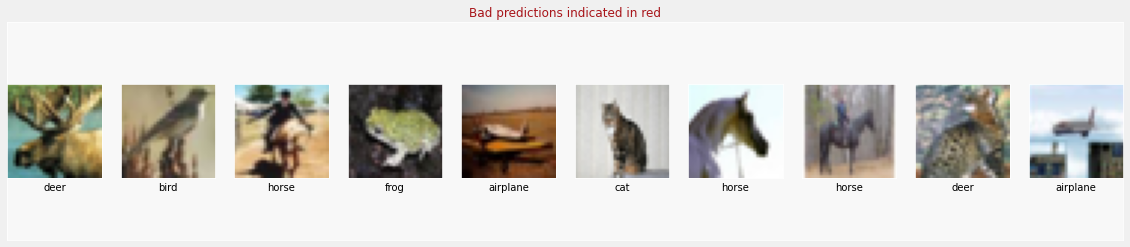

In [ ]:
# Visualize predictions
# take a look at the predictions on the validation set
predictions = model.predict(valid_X, batch_size=64)
predictions = np.argmax(predictions, axis=1)

display_images(validation_images, predictions, validation_labels, "Bad predictions indicated in red")

## Example 3. Image Classification and Object Localization on MNIST Dataset.

We'll build a CNN from scratch to classify the main subject in an image
localize it by drawing bounding boxes around it. We'll use the MNIST dataset to synthesize a custom dataset, in which each "digit" image is on a black canvas of width 75 x 75 at random locations. We calculate the corresponding bounding boxes for those "digits". The bounding box prediction can be modelled as a "regression" task, which means that the model will predict a numeric value (as opposed to a category).

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2


In [ ]:
## @title Plot Utilities for Bounding Boxes [RUN ME]

#  functions to draw bounding boxes around the digits
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness,
                               display_str_list)
  return np.array(rgbimg)
  

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)

In [ ]:
# functions to visualize the data and predictions.


## @title Visualization Utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. 

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
  return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = []
  if len(iou) > 0:
    n_iou = iou[indexes]

  if (len(pred_bboxes) > 0):
    n_pred_bboxes = pred_bboxes[indexes,:]

  if (len(bboxes) > 0):
    n_bboxes = bboxes[indexes,:]


  n_digits = n_digits * 255.0
  n_digits = n_digits.reshape(n, 75, 75)
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bboxes_to_plot.append(n_pred_bboxes[i])
    
    if (len(bboxes) > i):
      bboxes_to_plot.append(n_bboxes[i])

    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
    plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])
    
    if n_predictions[i] != n_labels[i]:
      ax.xaxis.label.set_color('red')

    
    
    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (n_iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

TPU or GPU detection: if the TPU is available, then you'll be using the TPU Strategy. Otherwise: 1) if more than one GPU is available, then you'll use the Mirrored Strategy and 2) if one GPU is available or if just the CPU is available, you'll use the default strategy.

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select Appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth
  # between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back
  print("Running on TPU", tpu.cluster_spec().as_dict()["worker"])
elif len(gpus)>1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print("Running on multiple GPUs", [gpu.name for gpu in gpus])
elif len(gpus)==1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print("Running on single GPU", gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() 
  print("Running on CPU")
print("Number of acceleratorsL ", strategy.num_replicas_in_sync)

Running on single GPU /device:GPU:0
Number of acceleratorsL  1


In [ ]:
# The global batch size is the batch size per replica (64 in this case) times the number of replicas in the distribution strategy.

BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

In [ ]:
# Load and Preprocess the data
"""
Transform each image in dataset by pasting it on a 75x75 canvas at a random location
"""
def read_image_tfds(image, label):
  x_min = tf.random.uniform((), 0, 48, dtype=tf.int32)
  y_min = tf.random.uniform((), 0, 48, dtype=tf.int32)
  image = tf.reshape(image, (28, 28, 1))
  image = tf.image.pad_to_bounding_box(image, y_min, x_min, 75, 75)
  image = tf.cast(image, tf.float32) / 255.0
  x_min = tf.cast(x_min, tf.float32)
  y_min = tf.cast(y_min, tf.float32)

  x_max = (x_min + 28) / 75
  y_max = (y_min + 28) / 75
  x_min = x_min / 75
  y_min = y_min / 75

  return image, (tf.one_hot(label, 10), [x_min, y_min, x_max, y_max])

"""
Loads and maps the training split of the dataset using the map function.
Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
"""
def get_training_dataset():
  with strategy.scope():
    dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True) # Google Cloud Storage
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # mandatory for Keras for now
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)# drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
  return dataset

"""
Loads and maps the validation split of the dataset using th map function. Same as Training ver
"""
def get_validation_dataset():
  with strategy.scope():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    # dataset = dataset.cached() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True)
    dataset = dataset.repeat()
    return dataset

# Instantiate the datasets
with strategy.scope():
  training_dataset = get_training_dataset()
  validation_dataset = get_validation_dataset()

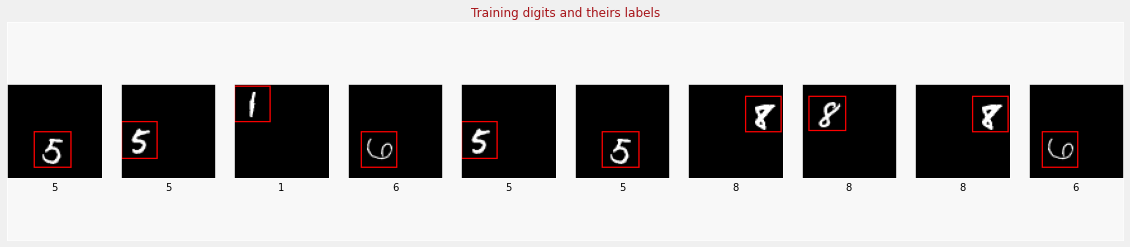

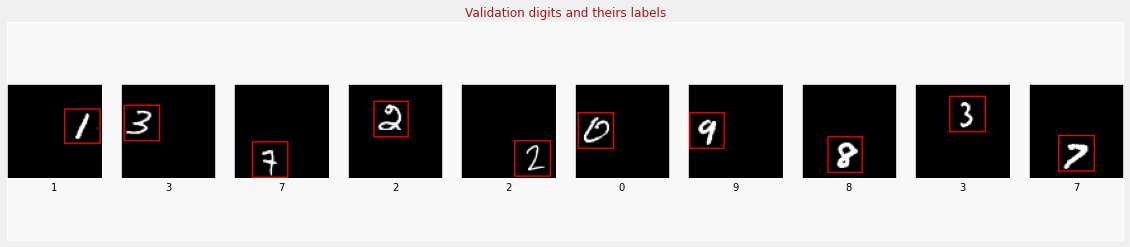

In [ ]:
# Visualize Data

(training_digits, training_labels, training_bboxes, 
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, 
                                                                                  validation_dataset, 10)

display_digits_with_boxes(training_digits, training_labels, training_labels, 
                          np.array([]), training_bboxes,np.array([]), "Training digits and theirs labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, 
                          np.array([]), validation_bboxes,np.array([]), "Validation digits and theirs labels")

In [ ]:
# Define the network

"""
Feature extractor is the CNN that is made up of convolution and pooling layers.
"""
def feature_extractor(inputs):
  x = tf.keras.layers.Conv2D(16, activation="relu", kernel_size=3,
                             input_shape=(75, 75, 1))(inputs)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)
  
  x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(x)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  return x

"""
Dense layers adds a flatten and dense layer.
This will follow the feature extraction layers.
"""
def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation="relu")(x)
  return x

"""
Classifier defines the classification output.
This has a set of fully connected layers and a softmax layer.
"""
def classifier(inputs):
  classification_output = tf.keras.layers.Dense(10, activation="softmax", name="classification")(inputs)
  return classification_output

"""
This function defines the regression output for the bounding box prediction.
Note that we have four outputs corresponding to (x_min, y_min, x_max, y_max)
"""
def bounding_box_regression(inputs):
  bounding_box_regression_output = tf.keras.layers.Dense(units=4, name="bounding_box")(inputs)
  return bounding_box_regression_output

def final_model(inputs):
  feature_cnn = feature_extractor(inputs)
  dense_output = dense_layers(feature_cnn)

  '''
  The model branch here.
  The Dense layer's output gets fed into two branches:
  classification_output and bounding_box_output
  '''
  classification_output = classifier(dense_output)
  bounding_box_output = bounding_box_regression(dense_output)

  model = tf.keras.Model(inputs=inputs, outputs=[classification_output, bounding_box_output])

  return model

def define_and_compile_model(inputs):
  model = final_model(inputs)

  model.compile(optimizer="adam",
                loss={
                    "classification":"categorical_crossentropy",
                    "bounding_box":"mse"
                },
                metrics={
                    "classification":"accuracy",
                    "bounding_box":"mse"
                })
  return model

with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1))
  model = define_and_compile_model(inputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 73, 73, 16)   160         ['input_3[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 36, 36, 16)  0           ['conv2d[0][0]']                 
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 34, 34, 32)   4640        ['average_pooling2d[0][0]']

In [ ]:
# Train and Validate the model
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE 
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)

loss, classification_loss, bouding_box_loss, classification_accuracy, bouding_box_mse = model.evaluate(validation_dataset, steps=validation_steps)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
937/937 [==============================] - 26s 24ms/step - loss: 1.0185 - classification_loss: 1.0035 - bounding_box_loss: 0.0150 - classification_accuracy: 0.6446 - bounding_box_mse: 0.0150 - val_loss: 0.3209 - val_classification_loss: 0.3115 - val_bounding_box_loss: 0.0095 - val_classification_accuracy: 0.9035 - val_bounding_box_mse: 0.0095
Epoch 2/10
937/937 [==============================] - 13s 14ms/step - loss: 0.2734 - classification_loss: 0.2666 - bounding_box_loss: 0.0068 - classification_accuracy: 0.9195 - bounding_box_mse: 0.0068 - val_loss: 0.2366 - val_classification_loss: 0.2314 - val_bounding_box_loss: 0.0052 - val_classification_accuracy: 0.9295 - val_bounding_box_mse: 0.0052
Epoch 3/10
937/937 [==============================] - 13s 14ms/step - loss: 0.2067 - classification_loss: 0.2028 - bounding_box_loss: 0.0040 - classification_accuracy: 0.9371 - bounding_box_mse: 0.0040 - val_loss: 0.1534 - val_classification_loss: 0.1501 - val_bounding_box_loss: 0.0033 -

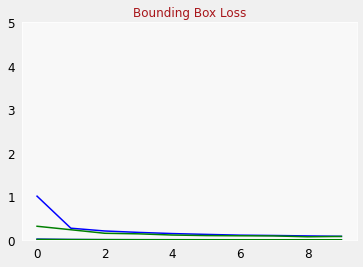

In [ ]:
# plotting the results
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")

In [ ]:
# Intersection over union in order to evaluate the model's performance for localization task.

def intersection_over_union(pred_box, true_box):
  x_min_pred, y_min_pred, x_max_pred, y_max_pred = np.split(pred_box, 4, axis=1)
  x_min_true, y_min_true, x_max_true, y_max_true = np.split(true_box, 4, axis=1)

  smoothing_factor = 1e-10

  x_min_overlap = np.maximum(x_min_pred, x_min_true)
  x_max_overlap = np.minimum(x_max_pred, x_max_true)
  y_min_overlap = np.maximum(y_min_pred, y_min_true)
  y_max_overlap = np.minimum(y_max_pred, y_max_true)

  true_box_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
  pred_box_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)

  overlap_area = np.maximum((x_max_overlap - x_min_overlap), 0) * np.maximum((y_max_overlap - y_min_overlap), 0)

  union_area = true_box_area + pred_box_area - overlap_area

  iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

  return iou

157/157 [==============================] - 1s 3ms/step
Number of predictions where iou > threshold(0.6): 9172
Number of predictions where iou < threshold(0.6): 828


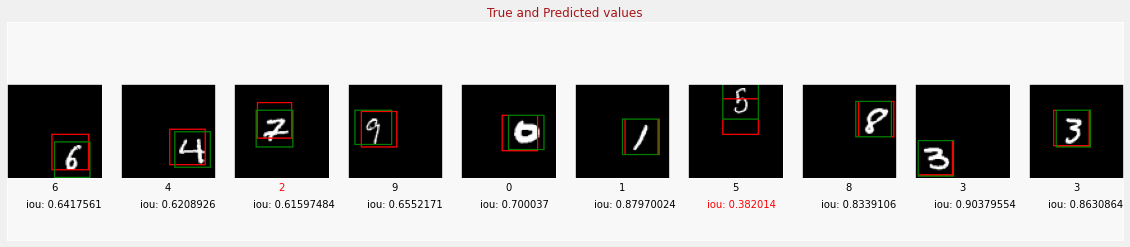

In [ ]:
# Visualize predictions both the classification and the predicted bounding boxes.
# The true bounding box labels will be in green, and the model's predicted bounding boxes are in red.
# The predicted number is shown below the image.

# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")


## Example 4. Predicting Bounding Boxes with Transfer Learning on Caltech Birds - 2010 Dataset.

Setup the data location: go to https://drive.google.com/drive/folders/1xgqUw9uWzL5Kh88iPdX1TBQgnkc-wVKd.
Next to the folder name "TF3 C3 W1 Data" (at the top of the page beside "Shared with me"), select "Add shortcut to Drive" A pop-up menu will open up. In the pop-up menu, "My Drive" is selected by default. Click the ADD SHORTCUT button. This should add a shortcut to the folder TF3 C3 W1 Data within your own google drive at the location content/drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [ ]:
# shortcut to the data
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

In [ ]:
# visualizing bounding boxes utilities
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image


In [ ]:
# visualizing data and prediction utilities

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
# preprocessing utilities

def read_image_tfds(image, bbox): # Resizes image to (224, 224), normalizes image and translates and normalizes bounding boxes
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

def read_image_with_shape(image, bbox): # Makes a copy of the original image, resizes image to (224, 224), normalizes image and translates and normalizes bounding boxes
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

def read_image_tfds_with_original_bbox(data): # reads image from data and denormalizes the bounding boxes (it undoes the bounding box normalization that is performed by the previous two helper functions.)
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list


def dataset_to_numpy_util(dataset, batch_size=0, N=0):  # converts a dataset into numpy arrays of images and boxes.

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0): # function converts a dataset into numpy arrays of: original images, resized and normalized images and bounding boxes
# This will be used for plotting the original images with true and predicted bounding boxes.

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='/content/drive/My Drive/TF3 C3 W1 Data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dty

<ipython-input-6-f7b3ff0a667e>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for images, bboxes in take_dataset:


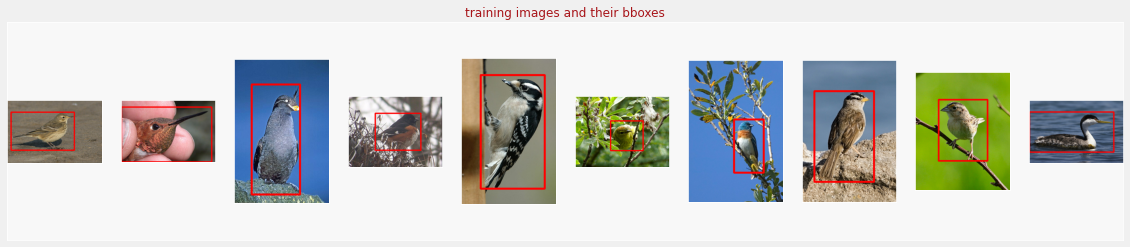

In [ ]:
# Visualize the images and their bounding box labels
# Now you'll take a random sample of images from the training and validation sets and visualize them by plotting the corresponding bounding boxes.

# Visualize the training images and their bounding box labels

def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")


<ipython-input-6-f7b3ff0a667e>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for images, bboxes in take_dataset:


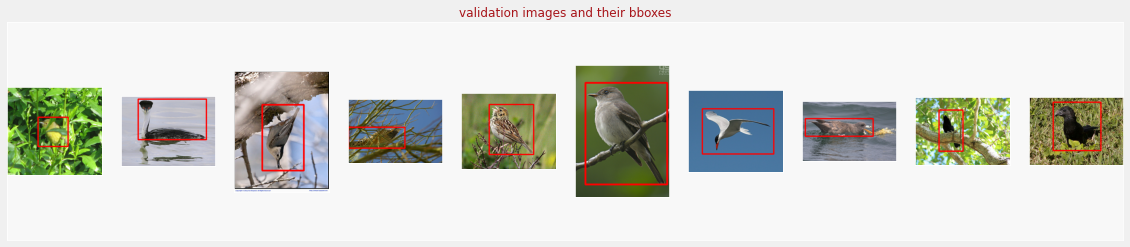

In [ ]:
# Visualize the validation images and their bounding boxes

def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")



In [ ]:
BATCH_SIZE = 64

# read and prepare the datasets that you'll feed to the model
def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

In [ ]:
# define the network

# pre-trained model as feature extractor
def feature_extractor(inputs):
    
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                                     include_top=False,
                                                                     weights="imagenet")
    
    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
        
    # return the feature_extractor
    return feature_extractor

# dense layers to be used by your model
def dense_layers(features):

    # global average pooling 2d layer
    x = tf.keras.layers.GlobalAveragePooling2D()(features)    
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x)
    
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    
    return x

# layer that outputs the bounding box predictions
def bounding_box_regression(x):
    
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(units=4, name="bounding_box")(x)

    return bounding_box_regression_output

# put together the above parts to build the final model
def final_model(inputs):

    # features
    feature_cnn = feature_extractor(inputs)

    # dense layers
    last_dense_layer = dense_layers(feature_cnn)

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(inputs=inputs, outputs=bounding_box_output)
        
    return model

# function to define and compile the final model
def define_and_compile_model():

    # define the input layer
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    # create the model
    model = final_model(inputs)
    
    # compile your model
    model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                  loss="mse")

    return model

In [ ]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                

In [ ]:
# You'll train 50 epochs
EPOCHS = 50

# Choose a batch size
BATCH_SIZE = 32

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = (length_of_training_dataset // BATCH_SIZE)+1

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1

In [ ]:
# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(training_dataset, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)

Epoch 1/50
94/94 [==============================] - 98s 874ms/step - loss: 0.0694 - val_loss: 0.3884
Epoch 2/50
94/94 [==============================] - 81s 863ms/step - loss: 0.0121 - val_loss: 0.2487
Epoch 3/50
94/94 [==============================] - 75s 802ms/step - loss: 0.0082 - val_loss: 0.1585
Epoch 4/50
94/94 [==============================] - 75s 804ms/step - loss: 0.0063 - val_loss: 0.1079
Epoch 5/50
94/94 [==============================] - 79s 844ms/step - loss: 0.0051 - val_loss: 0.0827
Epoch 6/50
94/94 [==============================] - 72s 765ms/step - loss: 0.0044 - val_loss: 0.0628
Epoch 7/50
94/94 [==============================] - 74s 790ms/step - loss: 0.0039 - val_loss: 0.0520
Epoch 8/50
94/94 [==============================] - 70s 751ms/step - loss: 0.0035 - val_loss: 0.0432
Epoch 9/50
94/94 [==============================] - 70s 750ms/step - loss: 0.0032 - val_loss: 0.0377
Epoch 10/50
94/94 [==============================] - 75s 799ms/step - loss: 0.0029 - val_lo

In [ ]:
# evaluate your trained model's performance by checking its loss value on the validation set.
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

95/95 [==============================] - 25s 260ms/step - loss: 0.0147
Loss:  0.014684648253023624


In [ ]:
# save your model
model.save("birds.h5")

In [ ]:
# download your model
from google.colab import files
files.download("birds.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

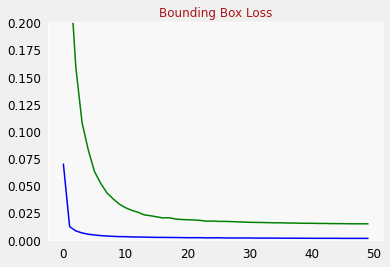

In [ ]:
# plot the loss metrics
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

In [ ]:
# Evaluate performance using IoU
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

 6/16 [==========>...................] - ETA: 3s

<ipython-input-6-f7b3ff0a667e>:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for original_images, images, bboxes in normalized_dataset:


16/16 [==============================] - 5s 235ms/step
Number of predictions where iou > threshold(0.5): 289
Number of predictions where iou < threshold(0.5): 211


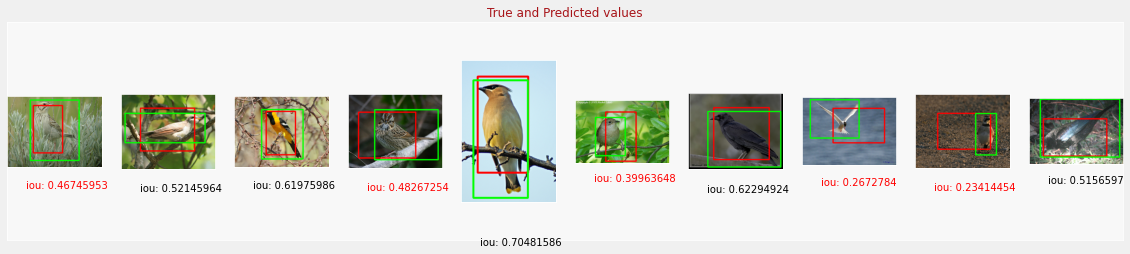

In [ ]:
# Visualize Predictions
# plot the predicted and ground truth bounding boxes for a random set of images and visually see how well you did!

n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)
